In [1]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from lightgbm import LGBMClassifier
import pandas as pd
import json
import sweetviz
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, PrecisionRecallDisplay
import seaborn as sns

In [2]:
data_train = pd.read_csv('../data/train.csv')

In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856610 entries, 0 to 856609
Data columns (total 16 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   observation_id                            856610 non-null  object 
 1   Type                                      856610 non-null  object 
 2   Date                                      856610 non-null  object 
 3   Part of a policing operation              646620 non-null  object 
 4   Latitude                                  700308 non-null  float64
 5   Longitude                                 700308 non-null  float64
 6   Gender                                    856610 non-null  object 
 7   Age range                                 856610 non-null  object 
 8   Self-defined ethnicity                    841427 non-null  object 
 9   Officer-defined ethnicity                 856610 non-null  object 
 10  Legislation         

In [4]:
data = pd.read_csv('../data/trial1.csv')


In [5]:
data_input = data.observation.apply(lambda x: json.loads(x)).apply(pd.Series).copy(deep=True)

In [6]:
data_input.columns

Index(['observation_id', 'Type', 'Date', 'Part of a policing operation',
       'Latitude', 'Longitude', 'Gender', 'Age range',
       'Officer-defined ethnicity', 'Legislation', 'Object of search',
       'station'],
      dtype='object')

In [7]:
data = pd.concat(
        [
            data.drop(columns=['Unnamed: 0', 'observation_id', 'id', 'observation']),
            data.observation.apply(lambda x: json.loads(x)).apply(pd.Series)
        ],
        axis=1
    )

In [8]:
data_train.loc[(data_train['Outcome']=='A no further action disposal') & (data_train['Outcome linked to object of search']==True), 'Outcome linked to object of search']=False

In [9]:
data_train = data_train[[*data_input.columns, 'Outcome linked to object of search']].dropna(subset='Outcome linked to object of search')

In [10]:
data_train = data_train.rename(columns={'Outcome linked to object of search':'true_label'}).reset_index(drop=True)

data train

                                             |          | [  0%]   00:00 -> (? left)


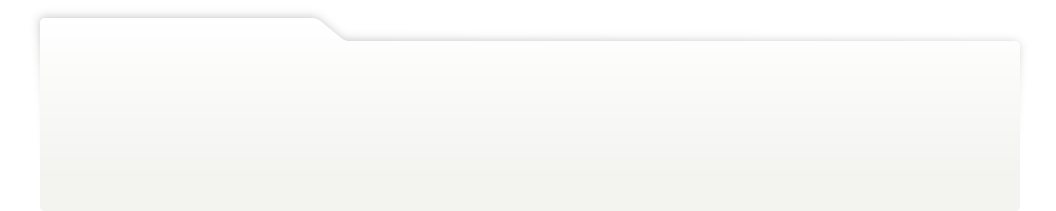
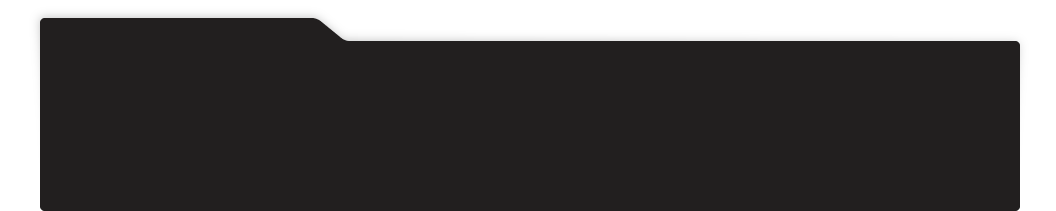
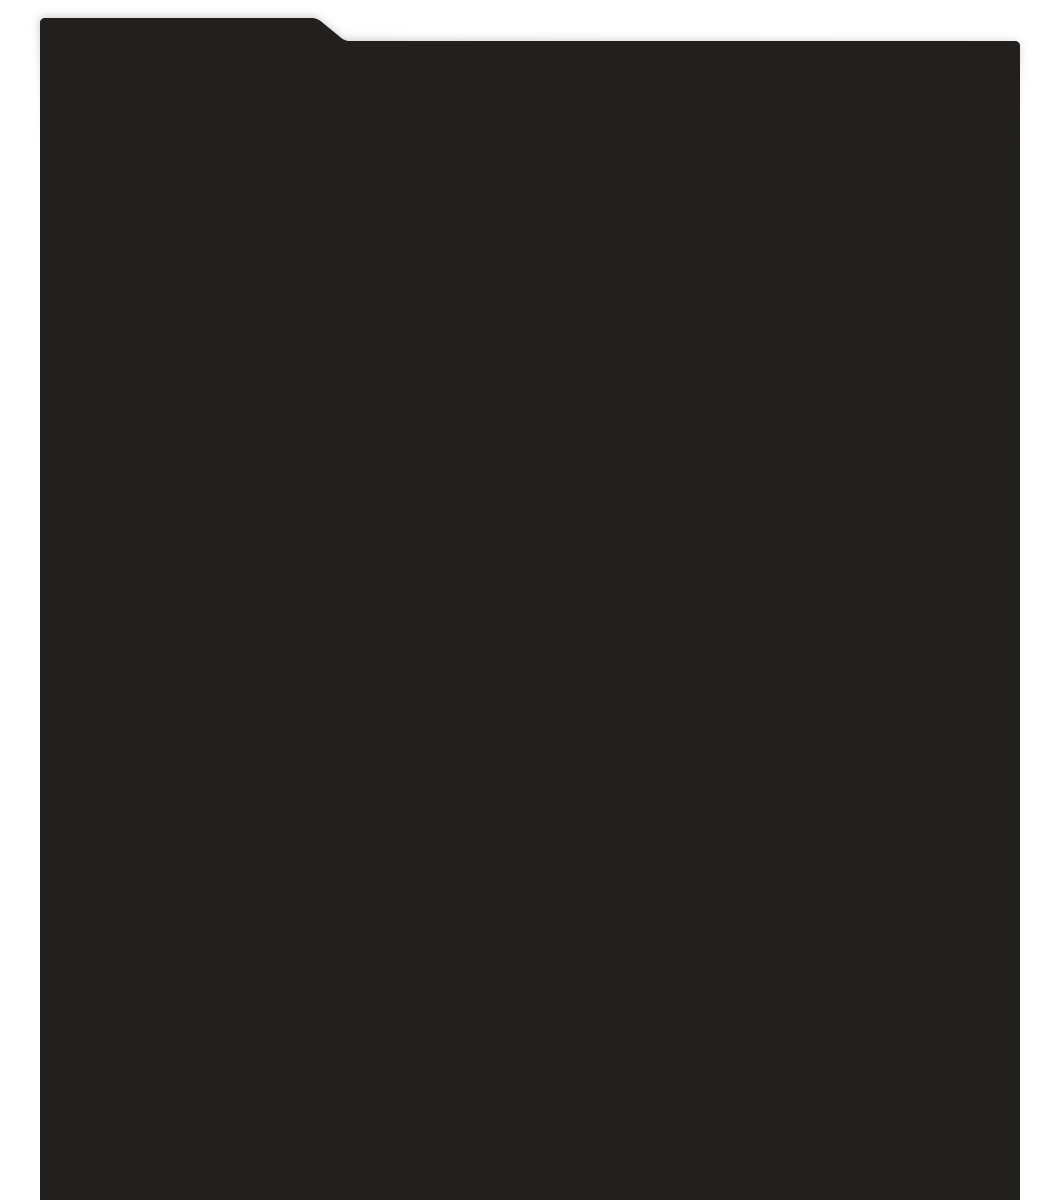
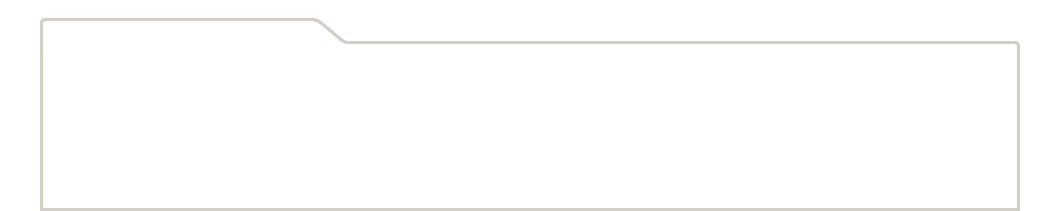
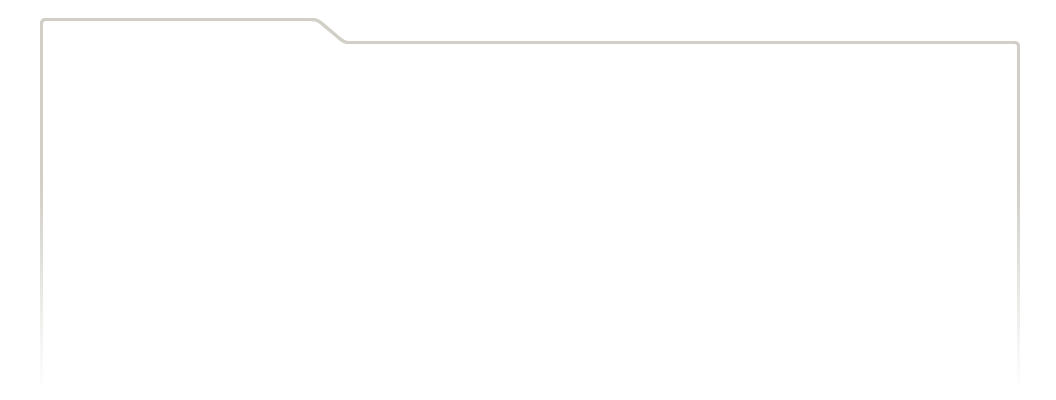
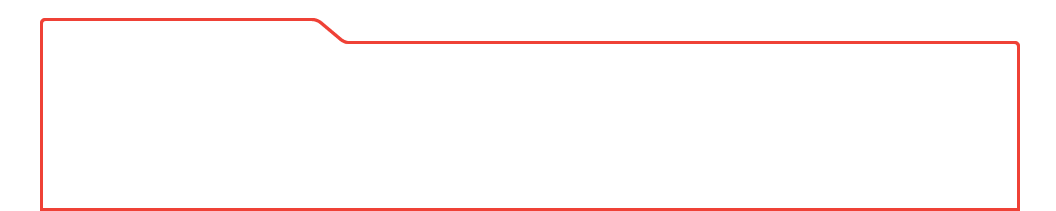
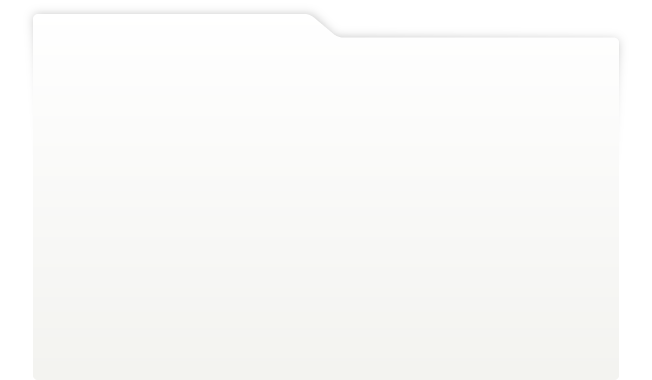
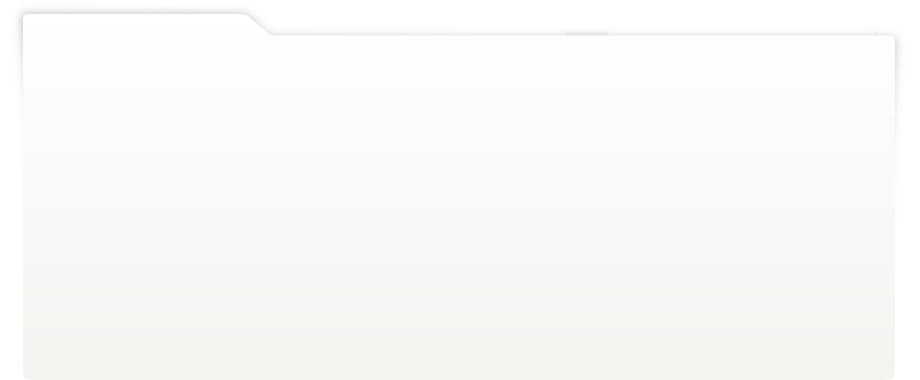
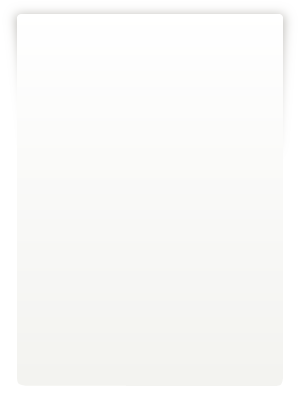
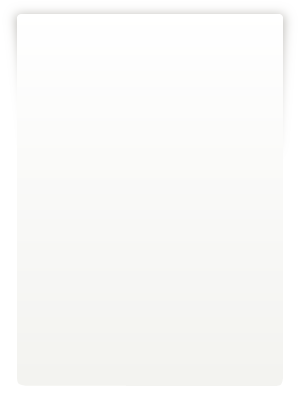
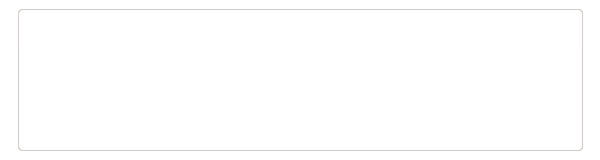
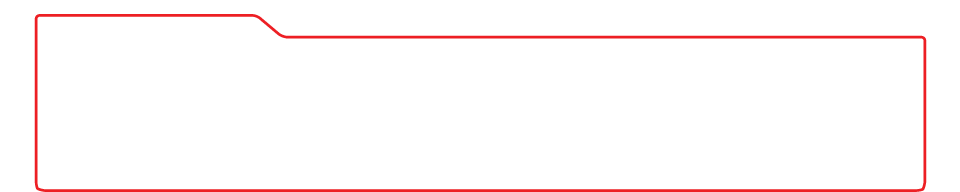
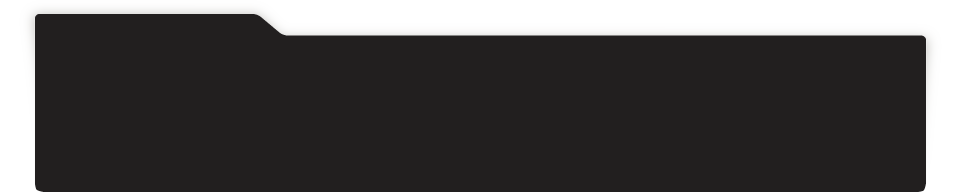
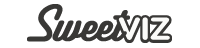
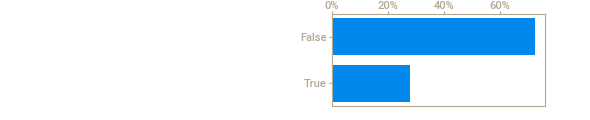
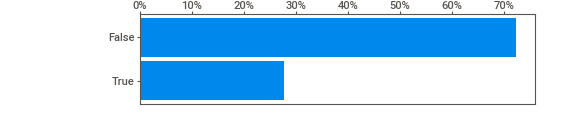
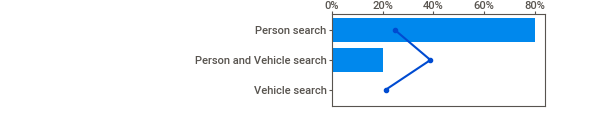
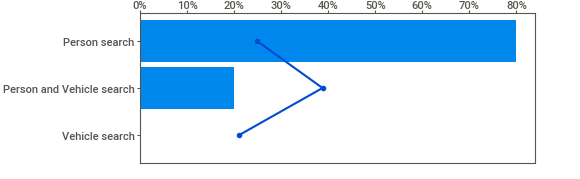
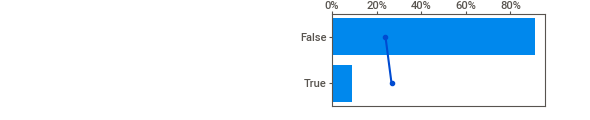
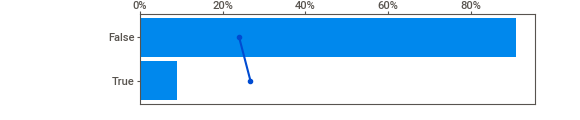
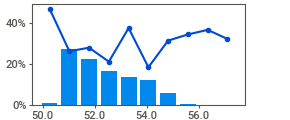
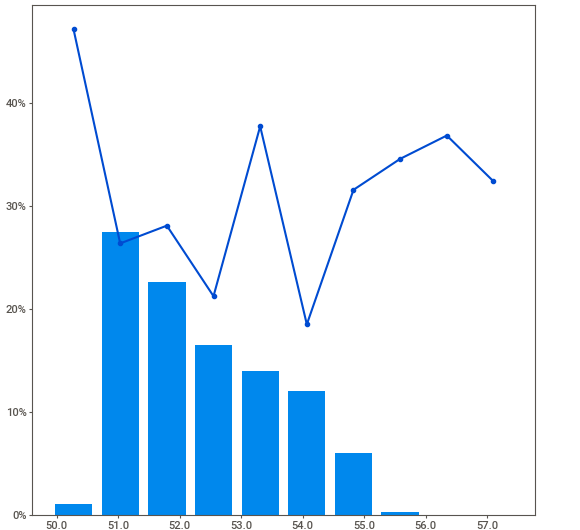
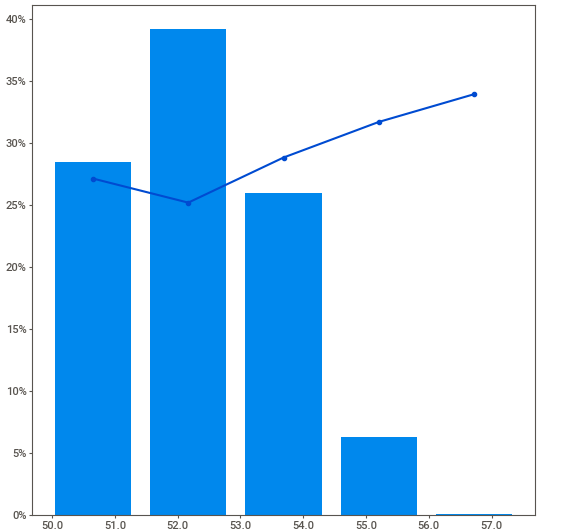
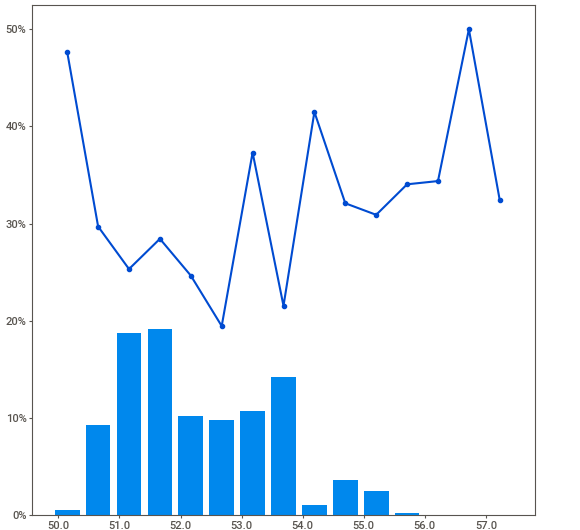
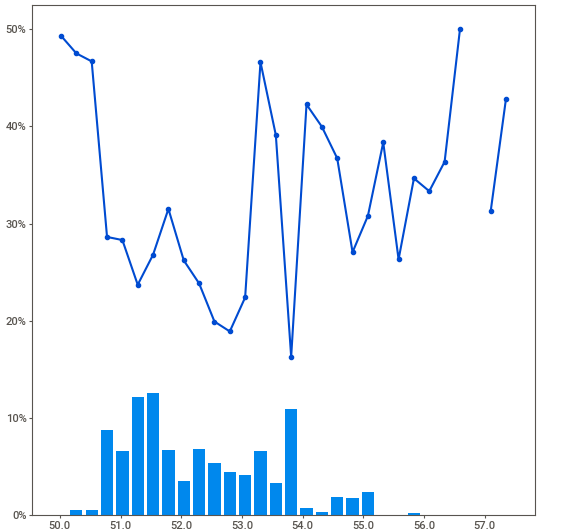
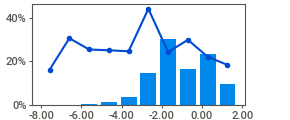
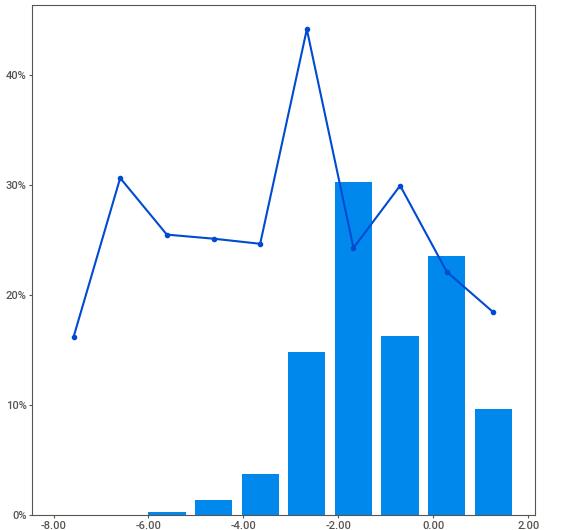
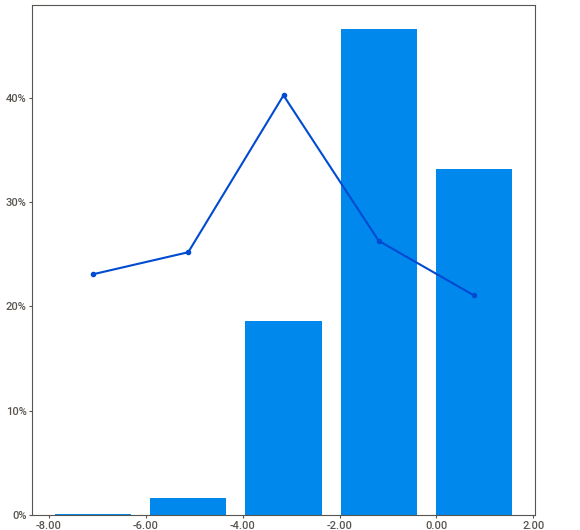
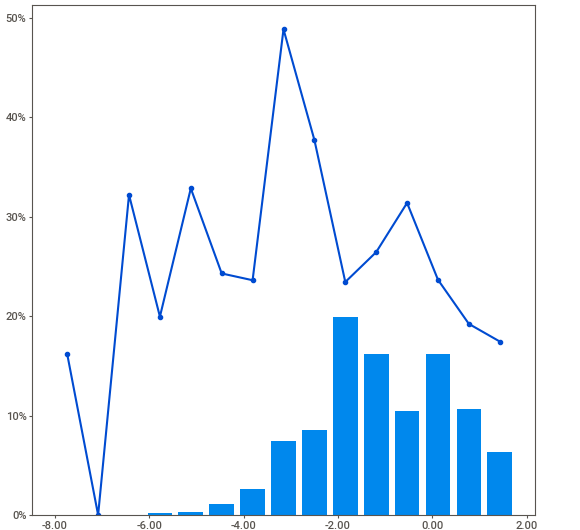
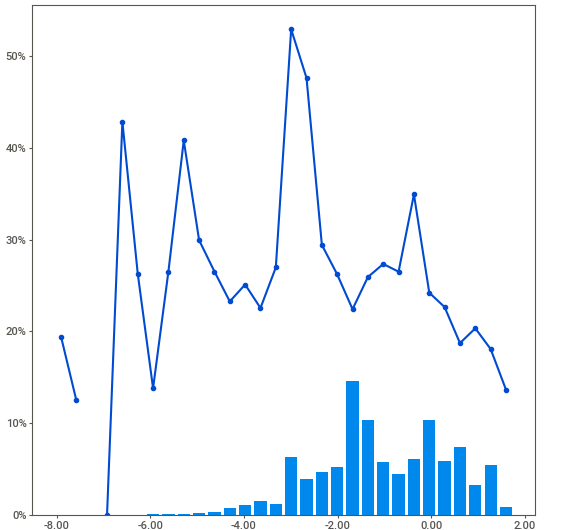
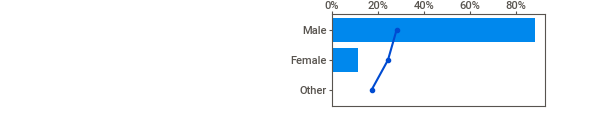
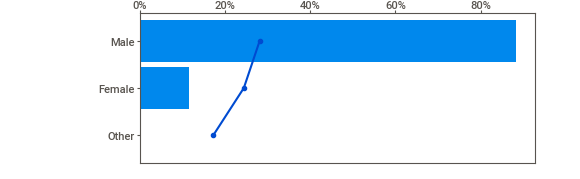
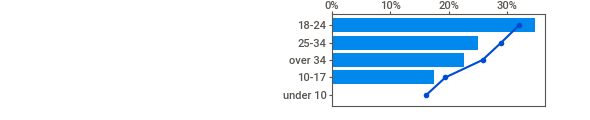
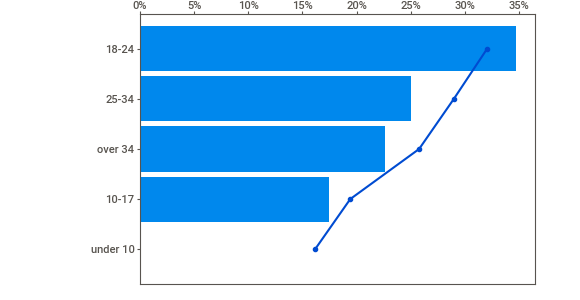
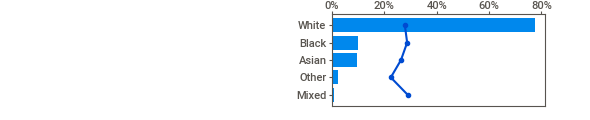
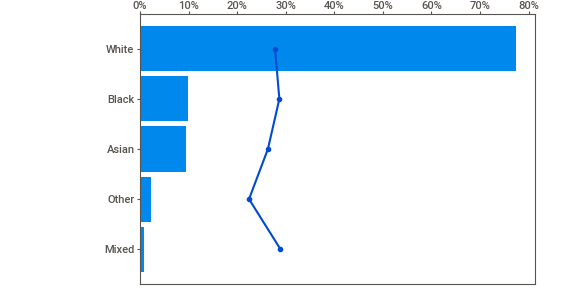
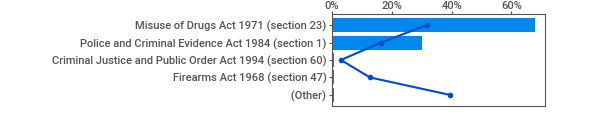
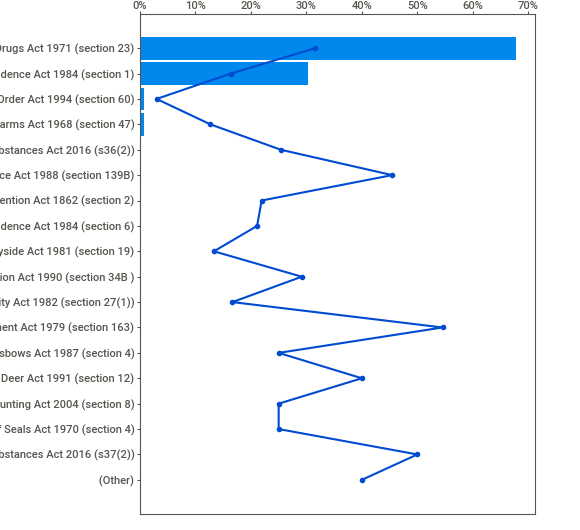
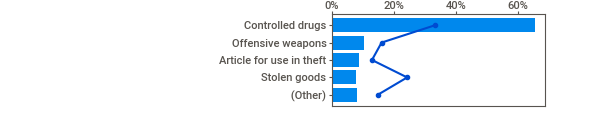
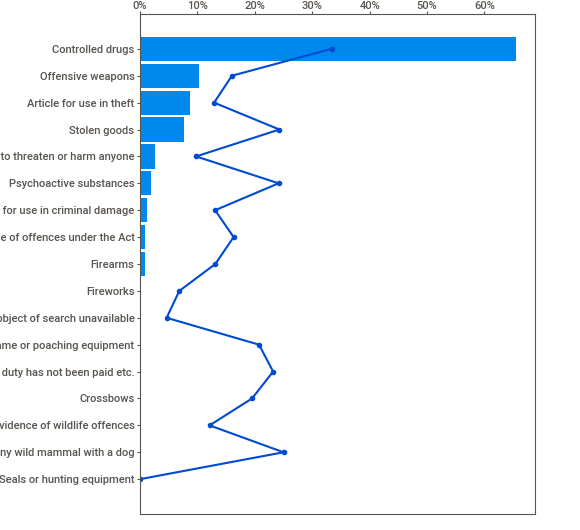
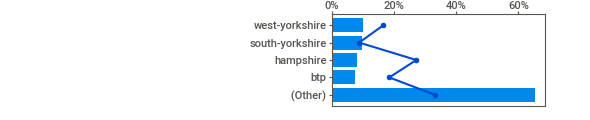
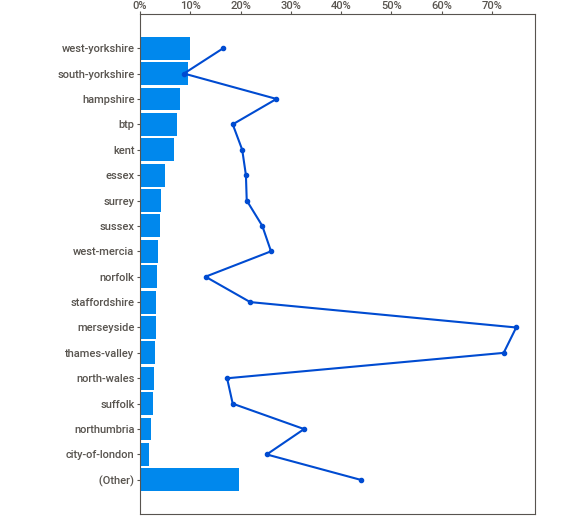
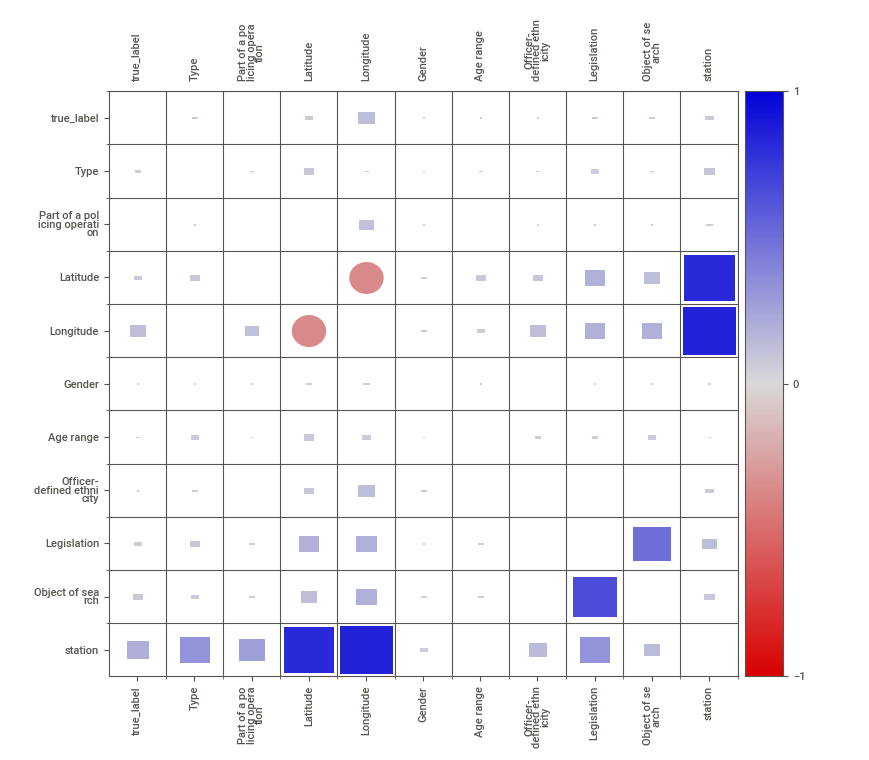
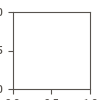

In [11]:
sweetviz.DataframeReport(data_train, target_feature_name='true_label').show_notebook()

In [12]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254683 entries, 0 to 254682
Data columns (total 13 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   observation_id                254683 non-null  object 
 1   Type                          254683 non-null  object 
 2   Date                          254683 non-null  object 
 3   Part of a policing operation  157982 non-null  object 
 4   Latitude                      203942 non-null  float64
 5   Longitude                     203942 non-null  float64
 6   Gender                        254683 non-null  object 
 7   Age range                     254683 non-null  object 
 8   Officer-defined ethnicity     254683 non-null  object 
 9   Legislation                   236164 non-null  object 
 10  Object of search              254683 non-null  object 
 11  station                       254683 non-null  object 
 12  true_label                    254683 non-nul

In [13]:
X_train = data_train.drop(columns='true_label')

In [14]:
y_train = data_train['true_label']

In [15]:
X_test = data_input

In [16]:
y_test = data.true_class

model trial

In [17]:
selected_columns = [
    'Type',
    'Gender',
    'Age range',
    'Object of search',
    'station',
    'Part of a policing operation',
    ]

In [18]:
X_test.columns

Index(['observation_id', 'Type', 'Date', 'Part of a policing operation',
       'Latitude', 'Longitude', 'Gender', 'Age range',
       'Officer-defined ethnicity', 'Legislation', 'Object of search',
       'station'],
      dtype='object')

In [19]:
from sklearn.impute import SimpleImputer


In [20]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254683 entries, 0 to 254682
Data columns (total 13 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   observation_id                254683 non-null  object 
 1   Type                          254683 non-null  object 
 2   Date                          254683 non-null  object 
 3   Part of a policing operation  157982 non-null  object 
 4   Latitude                      203942 non-null  float64
 5   Longitude                     203942 non-null  float64
 6   Gender                        254683 non-null  object 
 7   Age range                     254683 non-null  object 
 8   Officer-defined ethnicity     254683 non-null  object 
 9   Legislation                   236164 non-null  object 
 10  Object of search              254683 non-null  object 
 11  station                       254683 non-null  object 
 12  true_label                    254683 non-nul

In [21]:
data_train.columns

Index(['observation_id', 'Type', 'Date', 'Part of a policing operation',
       'Latitude', 'Longitude', 'Gender', 'Age range',
       'Officer-defined ethnicity', 'Legislation', 'Object of search',
       'station', 'true_label'],
      dtype='object')

In [22]:
[
    'Type',
    'Gender',
    'Age range',
    'Legislation',
    'Part of a policing operation',
    'Object of search',
    'station',] 

['Type',
 'Gender',
 'Age range',
 'Legislation',
 'Part of a policing operation',
 'Object of search',
 'station']

In [23]:
models = [
    LogisticRegression(max_iter=1000),
    # SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    GaussianNB()
]

model_names = [
    "Logistic Regression",
    # "Support Vector Classifier",
    "Decision Tree Classifier",
    "Random Forest Classifier",
    "Gradient Boosting Classifier",
    "Gaussian NB"
]

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.columns]

class CyclicalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, column, period):
        self.column = column
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X[self.column + '_sin'] = np.sin(2 * np.pi * X[self.column] / self.period)
        X[self.column + '_cos'] = np.cos(2 * np.pi * X[self.column] / self.period)
        X = X.drop(columns=self.column)
        return X

# Define a function to extract the day of week and hour from the date
def extract_date_info(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Hour'] = df['Date'].dt.hour
    df = df.drop(columns='Date')
    return df

date_transformer = FunctionTransformer(extract_date_info)

selected_columns = [
    'Type',
    'Gender',
    'Age range',
    'Legislation',
    'Part of a policing operation',
    'Object of search',
    'station',]  # replace this with your selected columns

# Define your models
classifiers = [
    LogisticRegression(max_iter=1000),
    # SVC(),
    DecisionTreeClassifier(),
    # RandomForestClassifier(),
    GradientBoostingClassifier(),
    # GaussianNB(),
    LGBMClassifier(),
]

classifier_names = [
    "Logistic Regression",
    # "Support Vector Classifier",
    "Decision Tree Classifier",
    # "Random t Classifier",
    "Gradient Boosting Classifier",
    # "Gaussian NB",
    "LightGBM"
]

# Define F2 scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

predictions = {}
probabilities = {}

for classifier, name in zip(classifiers, classifier_names):
    # Define your pipeline
    pipe = Pipeline([
        ('column_selector', ColumnTransformer([("selector", "passthrough", selected_columns)], remainder="drop")),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)),
        ('classifier', classifier),
    ])
    
    pipe.fit(X_train, y_train.astype('int').values.reshape(-1))
    
    # Use cross-validation to get a more robust measure of model performance
    predictions[name] = pipe.predict(X_test)
    probabilities[name] = pipe.predict_proba(X_test)[:, 1]  # probability of the positive class
    
    # Compute and print the F2 score
    score = fbeta_score(y_test, predictions[name], beta=2)
    
    print(f"{name} F2 Score: {score:.2f}")

Logistic Regression F2 Score: 0.48
Decision Tree Classifier F2 Score: 0.47
Gradient Boosting Classifier F2 Score: 0.42
LightGBM F2 Score: 0.47


In [24]:
pd.concat([X_train, X_test])

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station
0,2e4d0094-c30b-471b-a211-72a9790feca2,Person search,2020-12-01T01:10:00+00:00,NaN,50.798824,-1.089471,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Article for use in theft,hampshire
1,4779fbe8-6e05-4534-85fd-db32952ee309,Person search,2020-12-01T02:00:00+00:00,NaN,50.785099,-1.091540,Male,over 34,Other,Misuse of Drugs Act 1971 (section 23),Controlled drugs,hampshire
2,cb5c685d-acac-42e2-914d-75e6ff73b0a8,Person search,2020-12-01T09:15:00+00:00,NaN,50.952006,-1.403341,Male,over 34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,hampshire
3,f486e116-5b1e-45db-9931-a7f070c5c478,Person search,2020-12-01T10:20:00+00:00,NaN,50.806383,-1.079844,Male,10-17,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,hampshire
4,78f4020e-12cc-4889-bf1a-2f2c29b2f662,Person search,2020-12-01T10:24:00+00:00,NaN,50.806670,-1.081982,Male,10-17,Asian,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,hampshire
...,...,...,...,...,...,...,...,...,...,...,...,...
4015,dec81b01-b351-4030-b419-6044c91cd895,Person search,2022-03-13T02:45:00+00:00,False,50.213930,-5.300091,Male,over 34,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,devon-and-cornwall
4016,9c7e363f-26df-4b8a-92cf-b3cbf70827cc,Person search,2022-03-13T15:45:00+00:00,False,NaN,NaN,Male,over 34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,bedfordshire
4017,b08e103a-4f94-48c6-974f-1b746dde4ca0,Person and Vehicle search,2022-03-13T23:24:00+00:00,False,50.372266,-4.136544,Male,over 34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall
4018,493b76ae-8e5e-498d-8a9d-68eeeb8d51de,Person and Vehicle search,2022-03-14T03:22:00+00:00,False,50.630731,-3.565678,Female,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall


In [25]:
y_train.astype('int')

0         0
1         0
2         0
3         0
4         0
         ..
254678    0
254679    0
254680    1
254681    1
254682    1
Name: true_label, Length: 254683, dtype: int64

In [26]:
pd.concat([y_train.astype('int'), y_test.astype('int')]).values.reshape(-1)

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
pipe = Pipeline([
        ('column_selector', ColumnTransformer([("selector", "passthrough", selected_columns)], remainder="drop")),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)),
        ('classifier', LogisticRegression(max_iter=1000)),
    ])
    
pipe.fit(pd.concat([X_train, X_test]), pd.concat([y_train.astype('int'), y_test.astype('int')]).values.reshape(-1))

Pipeline(steps=[('column_selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['Type', 'Gender',
                                                   'Age range', 'Legislation',
                                                   'Part of a policing '
                                                   'operation',
                                                   'Object of search',
                                                   'station'])])),
                ('onehot',
                 OneHotEncoder(handle_unknown='ignore', sparse=False)),
                ('classifier', LogisticRegression(max_iter=1000))])

In [28]:
import os

In [29]:
TMP_DIR = 'save-model-LR-2'

In [30]:
if not os.path.exists(TMP_DIR):
   # Create a new directory because it does not exist
   os.makedirs(TMP_DIR)

In [31]:
import pickle
import joblib

In [32]:
with open(os.path.join(os.getcwd(), TMP_DIR, 'columns.json'), 'w') as file_save:
    json.dump(pd.concat([X_train, X_test]).columns.tolist(), file_save)
    
# pipeline

joblib.dump(pipe, os.path.join(os.getcwd(), TMP_DIR, 'pipeline.pickle'))

# dtypes

with open(os.path.join(os.getcwd(), TMP_DIR, 'dtypes.pickle'), 'wb') as file_save:
    pickle.dump(pd.concat([X_train, X_test]).dtypes, file_save)

In [33]:
predictions

{'Logistic Regression': array([0, 0, 0, ..., 1, 1, 1]),
 'Decision Tree Classifier': array([0, 0, 0, ..., 1, 1, 1]),
 'Gradient Boosting Classifier': array([0, 0, 0, ..., 0, 0, 1]),
 'LightGBM': array([0, 0, 0, ..., 1, 1, 1])}

In [34]:
probabilities

{'Logistic Regression': array([0.11290916, 0.17367095, 0.16977823, ..., 0.5313437 , 0.51052189,
        0.58506927]),
 'Decision Tree Classifier': array([0.02941176, 0.06666667, 0.31578947, ..., 0.51832461, 0.6       ,
        0.62910798]),
 'Gradient Boosting Classifier': array([0.13927644, 0.1743611 , 0.17199262, ..., 0.47176758, 0.47168748,
        0.52024814]),
 'LightGBM': array([0.07861388, 0.10683698, 0.22506927, ..., 0.53289555, 0.5153883 ,
        0.60794093])}

In [35]:


def verify_no_discrimination(X_test, y_true, y_pred, sensitive_column='Gender', max_diff=0.05):
    """
    Verifies that no station has discrimination in sensitive_column
    
    
    """
    
    departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department)
            if mask.sum():
                precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1, zero_division=0)
                
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff > max_diff:
            is_satisfied = False
            problematic_departments.append((department, diff, precisions))
        else:
            good_deparments.append((department, diff, precisions))

    return is_satisfied, problematic_departments, good_deparments

def verify_across_stations(X_test, y_true, y_pred, max_diff=0.1, min_success_rate=0.1):
    """
    Verifies that no station has discrimination in sensitive_column
    
    
    """
    
    departments = X_test['station'].unique()

    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    precisions = []
    for department in departments:
        mask = (X_test['station'] == department)
        if mask.sum():
            station_precision = precision_score(y_true[mask], y_pred[mask], pos_label=1, zero_division=0)
            precisions.append(station_precision)

        if station_precision < min_success_rate:
            problematic_departments.append((department, station_precision))
        else:
            good_deparments.append((department, station_precision))

    diff = np.max(precisions) - np.min(precisions)
    if diff > max_diff:
            is_satisfied = False

    return is_satisfied, diff, problematic_departments, good_deparments

In [36]:
thresholds_list = np.arange(0.0, 1.1, 0.1)

stations removed


/home/jrr/.virtualenvs/capstone/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jrr/.virtualenvs/capstone/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


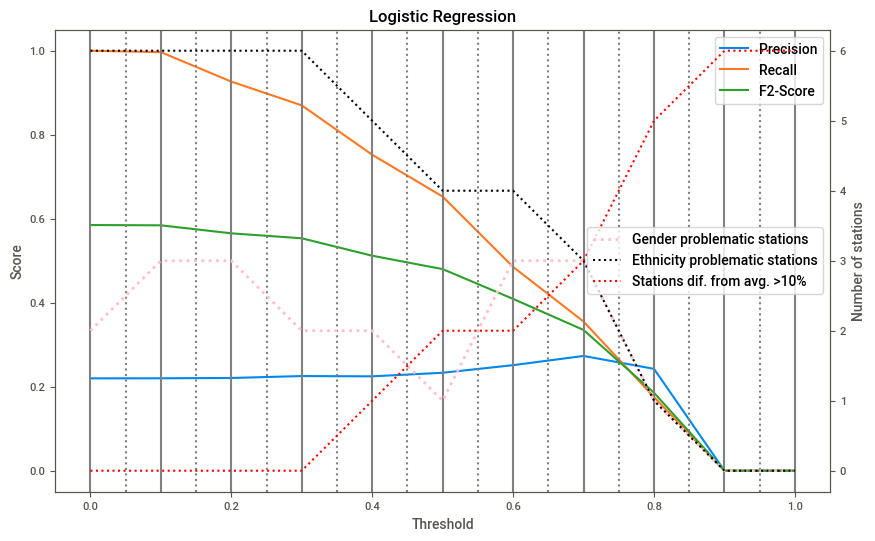

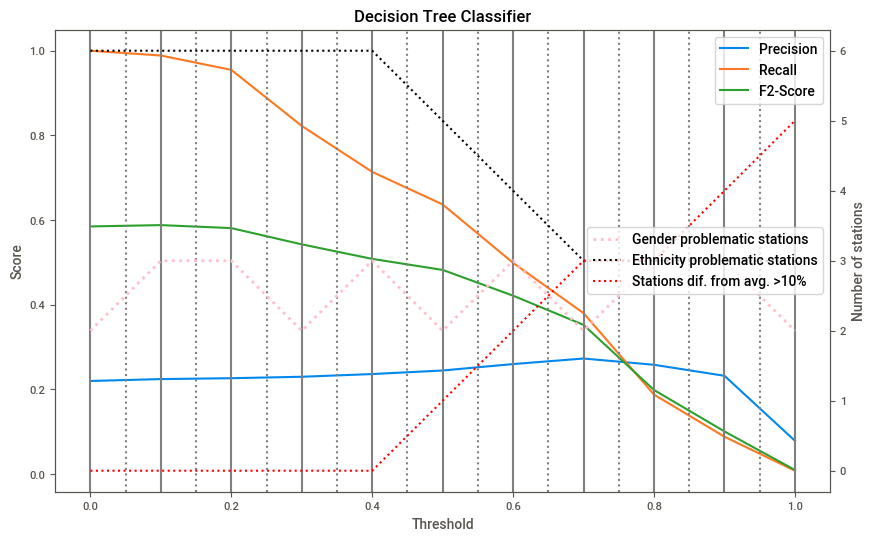

/home/jrr/.virtualenvs/capstone/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jrr/.virtualenvs/capstone/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


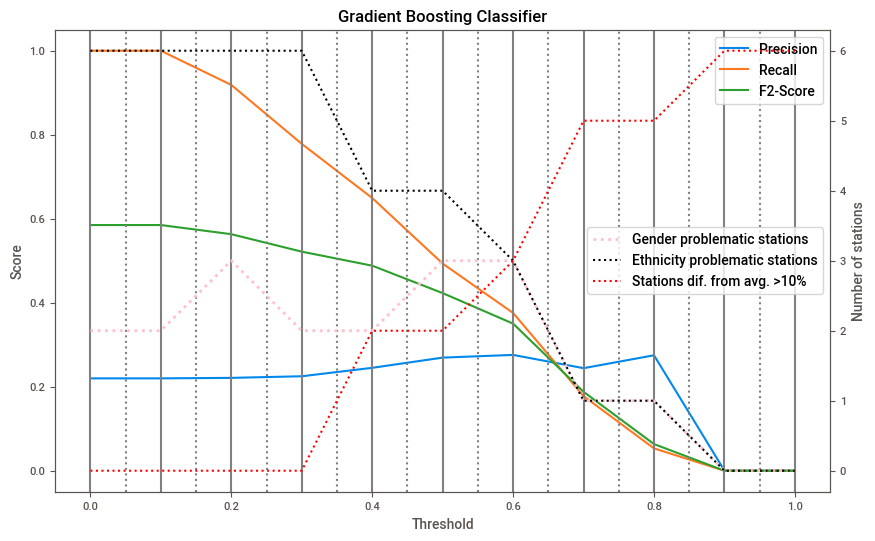

/home/jrr/.virtualenvs/capstone/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


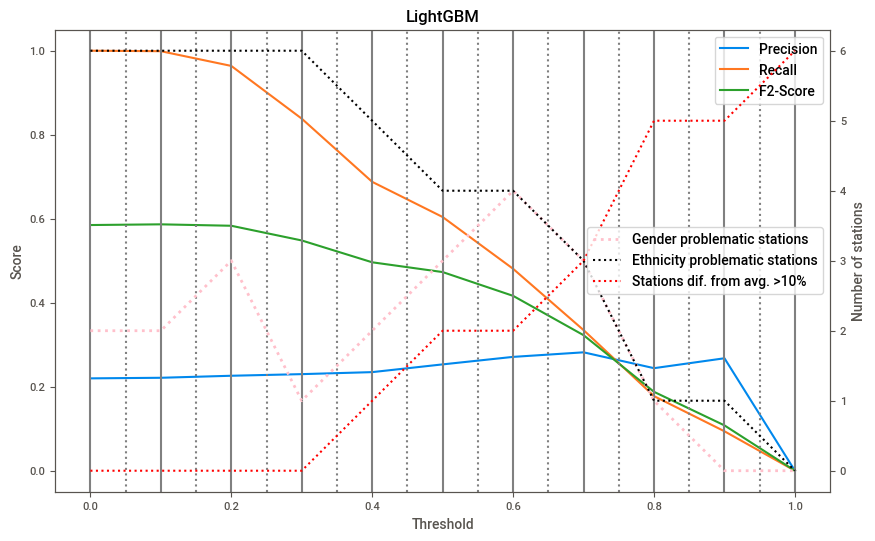

In [37]:
for model_name, model_proba in  probabilities.items():
    precisions = []
    recalls = []
    f2_scores = []
    gender_discrimination_stations = []
    race_discrimination_stations = []
    stations_precision_diff = []
    stations_problematic_departments = []

    for threshold in list(thresholds_list):
        # Binarize predictions based on threshold
        y_pred = [1 if score >= threshold else 0 for score in model_proba]

        _, gender_problematic_departments, _ = verify_no_discrimination(X_test, y_test, pd.Series(y_pred), sensitive_column='Gender')
        _, race_problematic_departments, _ = verify_no_discrimination(X_test, y_test, pd.Series(y_pred), sensitive_column='Officer-defined ethnicity')
        _, across_stations_diff, across_stations_problematic_departments, _ = verify_across_stations(X_test, y_test, pd.Series(y_pred))
        # Calculate precision, recall, F2-score, and support
        precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, beta=2, average='binary')
        # Append the scores to the lists
        precisions.append(precision)
        recalls.append(recall)
        f2_scores.append(fscore)
        stations_precision_diff.append(across_stations_diff)

        gender_discrimination_stations.append(len(gender_problematic_departments))
        race_discrimination_stations.append(len(race_problematic_departments))
        stations_problematic_departments.append(len(across_stations_problematic_departments))

    #_______________________________plot_________________

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    # Plot the metrics on the first Axes
    ax1.plot(thresholds_list, precisions, label='Precision')
    ax1.plot(thresholds_list, recalls, label='Recall')
    ax1.plot(thresholds_list, f2_scores, label='F2-Score')

    # Plot the additional variable on the second Axes
    ax2.plot(thresholds_list, gender_discrimination_stations, label='Gender problematic stations', linestyle=':', color='pink', linewidth=2)
    ax2.plot(thresholds_list, race_discrimination_stations, label='Ethnicity problematic stations', linestyle=':', color='black')
    ax2.plot(thresholds_list, stations_problematic_departments, label='Stations dif. from avg. >10%', linestyle=':', color='red')


    # Add vertical lines at 0.1 (continuous line)
    for x in np.arange(0.0, 1.1, 0.1):
        ax1.axvline(x, color='gray', linestyle='-')

    # Add vertical lines at 0.05 (dotted line)
    for x in np.arange(0.05, 1.05, 0.1):
        ax1.axvline(x, color='gray', linestyle=':')

    # Label the axes and create a legend
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Score')
    ax1.legend(loc='upper right')

    ax2.set_ylabel('Number of stations')
    ax2.legend(loc='center right')

    # Show the plot
    plt.title(model_name)
    plt.show()

/home/jrr/.virtualenvs/capstone/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jrr/.virtualenvs/capstone/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


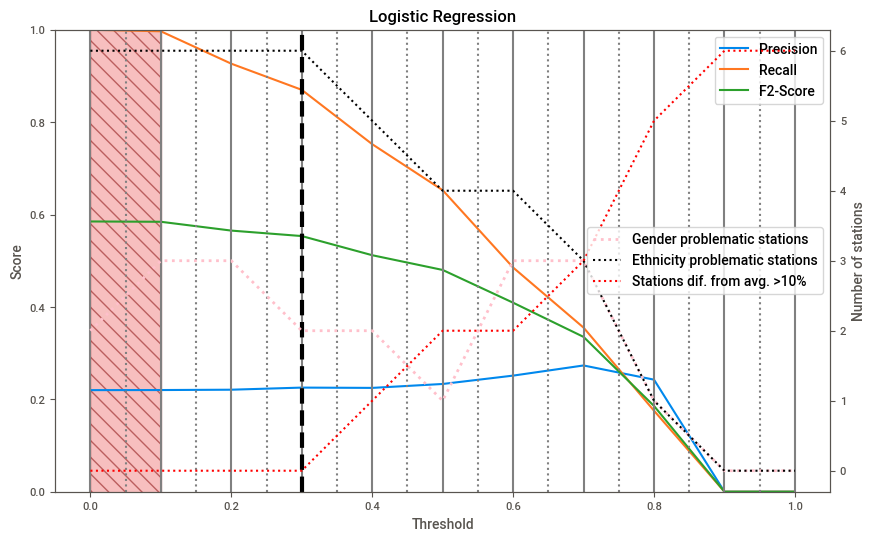

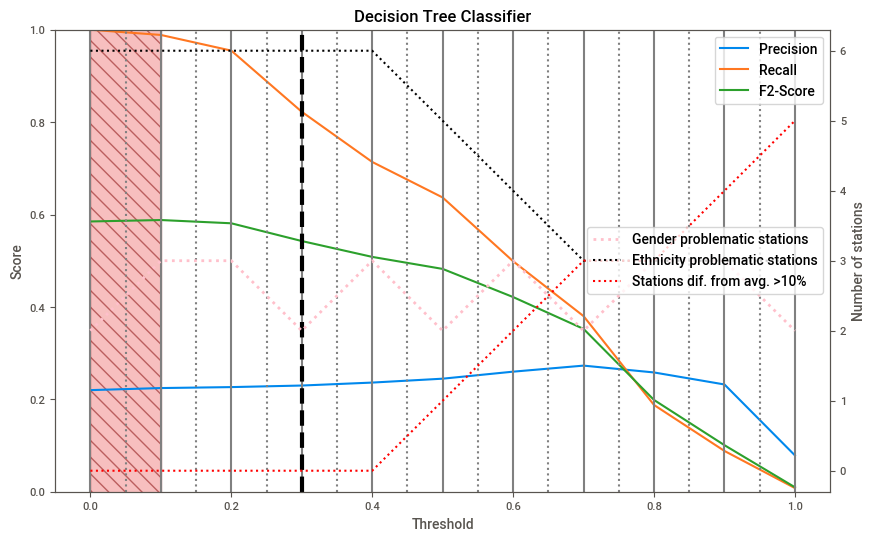

/home/jrr/.virtualenvs/capstone/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jrr/.virtualenvs/capstone/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


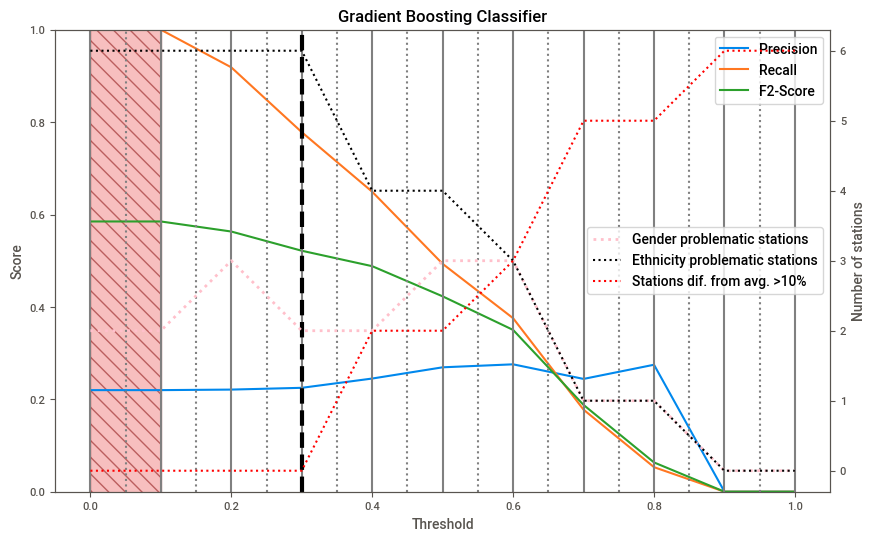

/home/jrr/.virtualenvs/capstone/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


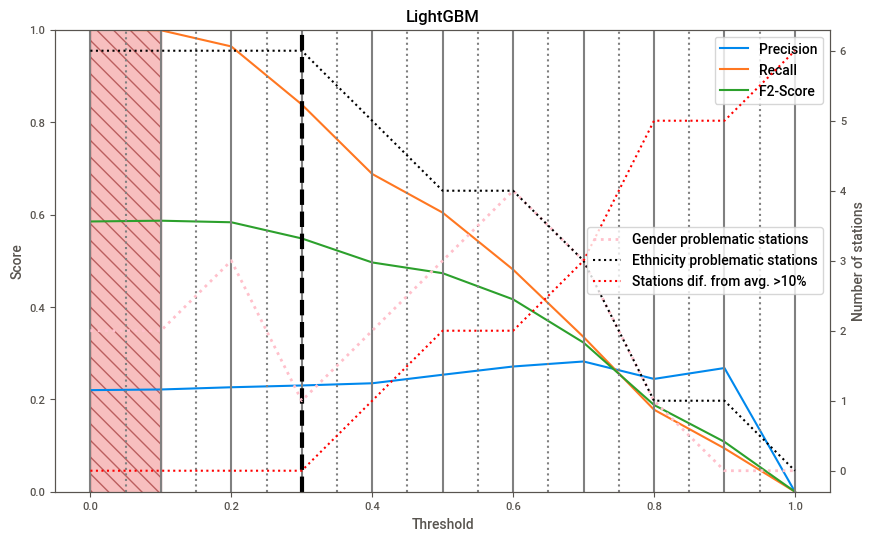

In [48]:
for model_name, model_proba in  probabilities.items():
    precisions = []
    recalls = []
    f2_scores = []
    gender_discrimination_stations = []
    race_discrimination_stations = []
    stations_precision_diff = []
    stations_problematic_departments = []

    for threshold in list(thresholds_list):
        # Binarize predictions based on threshold
        y_pred = [1 if score >= threshold else 0 for score in model_proba]

        _, gender_problematic_departments, _ = verify_no_discrimination(X_test, y_test, pd.Series(y_pred), sensitive_column='Gender')
        _, race_problematic_departments, _ = verify_no_discrimination(X_test, y_test, pd.Series(y_pred), sensitive_column='Officer-defined ethnicity')
        _, across_stations_diff, across_stations_problematic_departments, _ = verify_across_stations(X_test, y_test, pd.Series(y_pred))
        # Calculate precision, recall, F2-score, and support
        precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, beta=2, average='binary')
        # Append the scores to the lists
        precisions.append(precision)
        recalls.append(recall)
        f2_scores.append(fscore)
        stations_precision_diff.append(across_stations_diff)

        gender_discrimination_stations.append(len(gender_problematic_departments))
        race_discrimination_stations.append(len(race_problematic_departments))
        stations_problematic_departments.append(len(across_stations_problematic_departments))

    #_______________________________plot_________________

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    # Plot the metrics on the first Axes
    ax1.plot(thresholds_list, precisions, label='Precision')
    ax1.plot(thresholds_list, recalls, label='Recall')
    ax1.plot(thresholds_list, f2_scores, label='F2-Score')

    # Plot the additional variable on the second Axes
    ax2.plot(thresholds_list, gender_discrimination_stations, label='Gender problematic stations', linestyle=':', color='pink', linewidth=2)
    ax2.plot(thresholds_list, race_discrimination_stations, label='Ethnicity problematic stations', linestyle=':', color='black')
    ax2.plot(thresholds_list, stations_problematic_departments, label='Stations dif. from avg. >10%', linestyle=':', color='red')


    # Add vertical lines at 0.1 (continuous line)
    for x in np.arange(0.0, 1.1, 0.1):
        ax1.axvline(x, color='gray', linestyle='-')

    # Add vertical lines at 0.05 (dotted line)
    for x in np.arange(0.05, 1.05, 0.1):
        ax1.axvline(x, color='gray', linestyle=':')

    ax1.axvline(0.3, color='black', linestyle='--', linewidth=3)

    ax1.fill_between([0,0.1], -1, 2, alpha=0.5, facecolor="lightcoral",
                     edgecolor="maroon", hatch=r"\\" )

    # Label the axes and create a legend
    ax1.set_ylim(0, 1)
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Score')
    ax1.legend(loc='upper right')

    ax2.set_ylabel('Number of stations')
    ax2.legend(loc='center right')

    # Show the plot
    plt.title(model_name)
    plt.show()

/home/jrr/.virtualenvs/capstone/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jrr/.virtualenvs/capstone/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


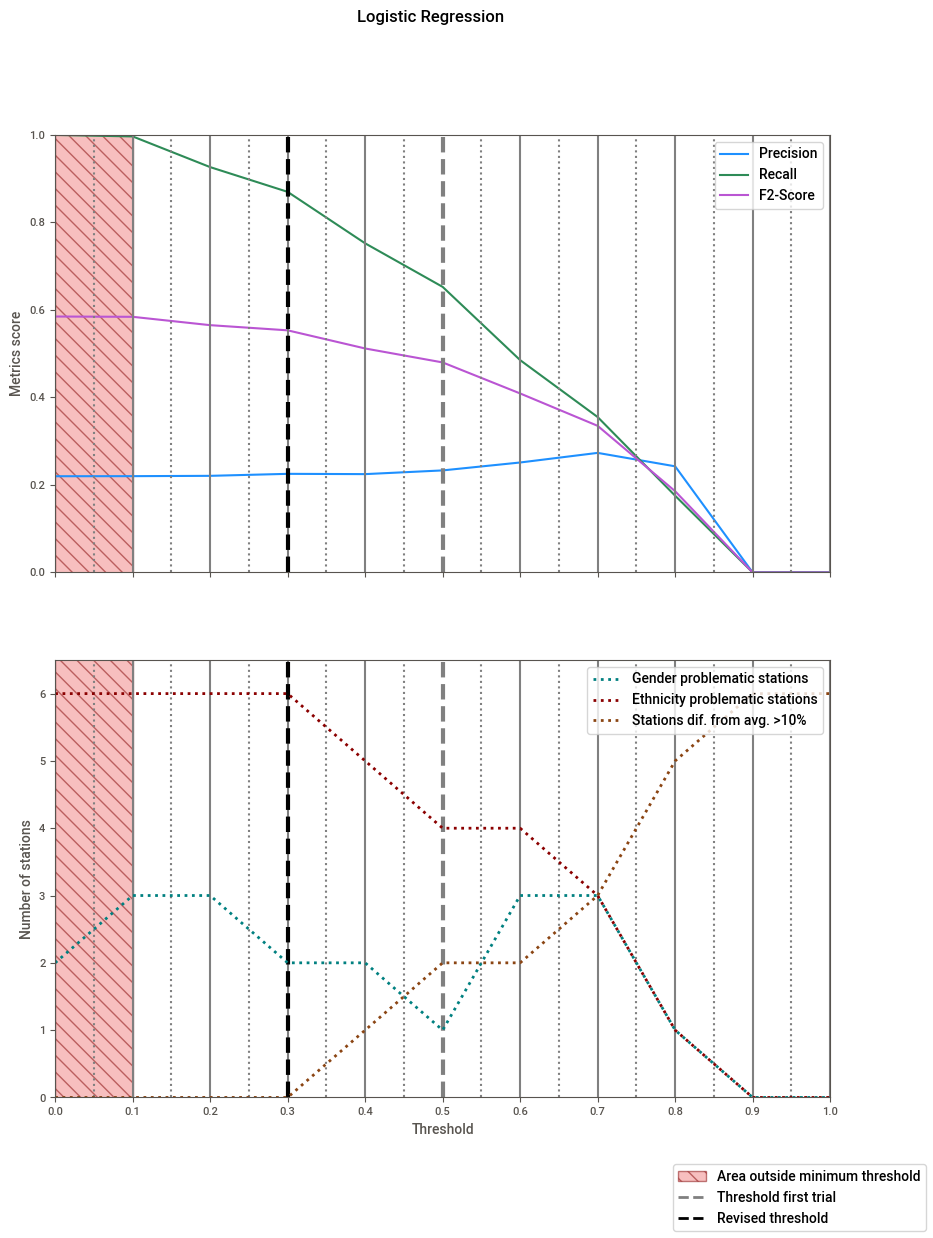

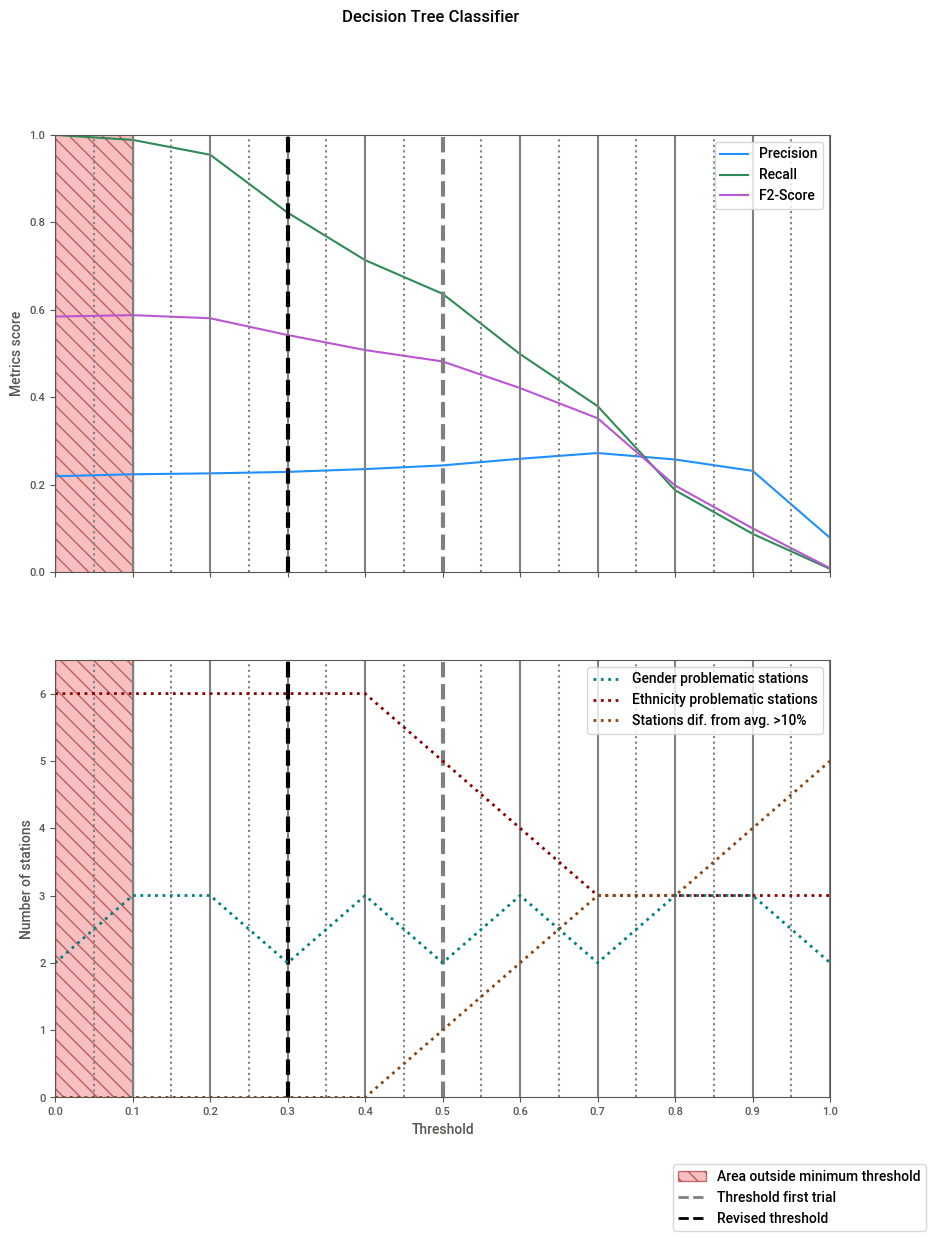

/home/jrr/.virtualenvs/capstone/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jrr/.virtualenvs/capstone/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


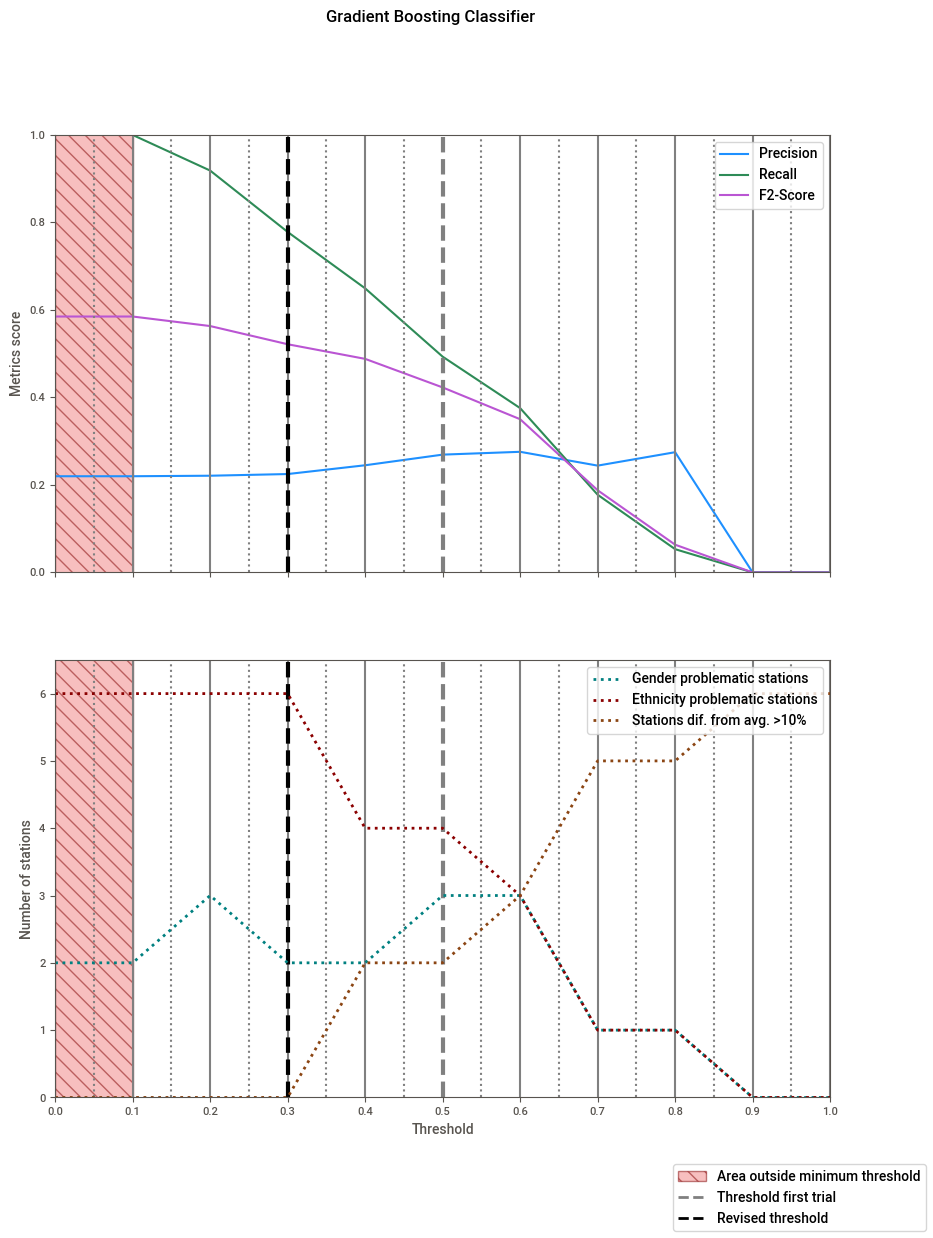

/home/jrr/.virtualenvs/capstone/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


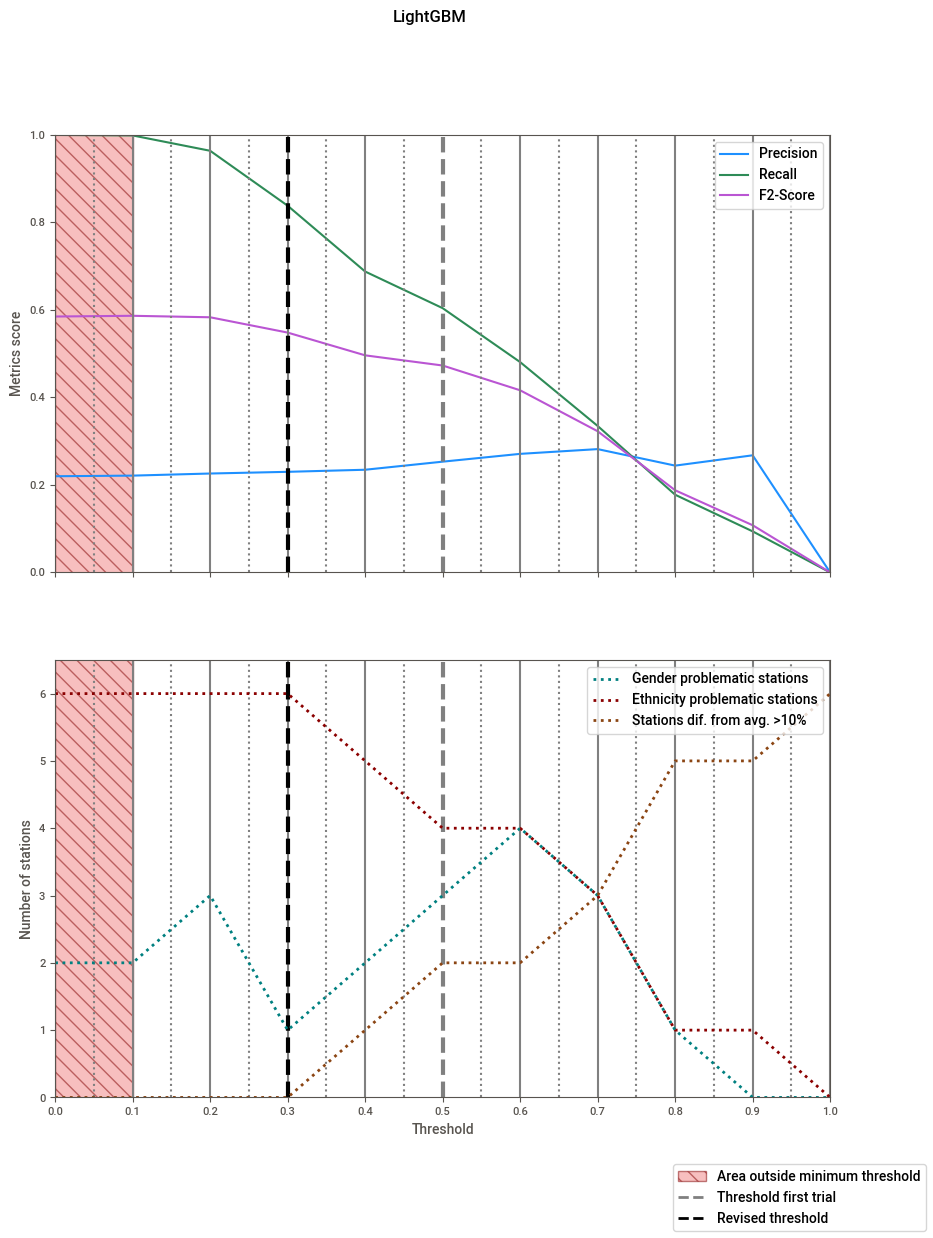

In [76]:
from matplotlib.lines import Line2D

for model_name, model_proba in  probabilities.items():
    precisions = []
    recalls = []
    f2_scores = []
    gender_discrimination_stations = []
    race_discrimination_stations = []
    stations_precision_diff = []
    stations_problematic_departments = []

    for threshold in list(thresholds_list):
        # Binarize predictions based on threshold
        y_pred = [1 if score >= threshold else 0 for score in model_proba]

        _, gender_problematic_departments, _ = verify_no_discrimination(X_test, y_test, pd.Series(y_pred), sensitive_column='Gender')
        _, race_problematic_departments, _ = verify_no_discrimination(X_test, y_test, pd.Series(y_pred), sensitive_column='Officer-defined ethnicity')
        _, across_stations_diff, across_stations_problematic_departments, _ = verify_across_stations(X_test, y_test, pd.Series(y_pred))
        # Calculate precision, recall, F2-score, and support
        precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, beta=2, average='binary')
        # Append the scores to the lists
        precisions.append(precision)
        recalls.append(recall)
        f2_scores.append(fscore)
        stations_precision_diff.append(across_stations_diff)

        gender_discrimination_stations.append(len(gender_problematic_departments))
        race_discrimination_stations.append(len(race_problematic_departments))
        stations_problematic_departments.append(len(across_stations_problematic_departments))

    #_______________________________plot_________________

    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10, 12.5))

    # Plot the metrics on the first Axes
    ax1.plot(thresholds_list, precisions, label='Precision', color='dodgerblue')
    ax1.plot(thresholds_list, recalls, label='Recall', color='seagreen')
    ax1.plot(thresholds_list, f2_scores, label='F2-Score', color='mediumorchid')

    # Add vertical lines at 0.1 (continuous line)
    for x in np.arange(0.0, 1.1, 0.1):
        if x not in [0.3, 0.5]:
            ax1.axvline(x, color='gray', linestyle='-')
            ax2.axvline(x, color='gray', linestyle='-')

    # Add vertical lines at 0.05 (dotted line)
    for x in np.arange(0.05, 1.05, 0.1):
        ax1.axvline(x, color='gray', linestyle=':')
        ax2.axvline(x, color='gray', linestyle=':')

    ax1.axvline(0.3, color='black', linestyle='--', linewidth=3)
    ax2.axvline(0.3, color='black', linestyle='--', linewidth=3)
    ax1.axvline(0.5, color='grey', linestyle='--', linewidth=3)
    ax2.axvline(0.5, color='grey', linestyle='--', linewidth=3)


    fill_between = ax1.fill_between([0, 0.1], -1, 2, alpha=0.5, facecolor="lightcoral", edgecolor="maroon", hatch=r"\\")
    ax2.fill_between([0, 0.1], -1, 7, alpha=0.5, facecolor="lightcoral", edgecolor="maroon", hatch=r"\\")
    
    custom_lines = [Line2D([0], [0], color='grey', lw=2, linestyle='--'), Line2D([0], [0], color='black', lw=2, linestyle='--')]

    # Label the axes and create a legend for the first plot
    ax1.set_ylim(0, 1)
    ax1.set_xlim(0, 1)
    ax1.set_ylabel('Metrics score')
    ax1.legend(loc='upper right')

    # Plot the problematic stations on the second Axes
    ax2.plot(thresholds_list, gender_discrimination_stations, label='Gender problematic stations', lw=2, linestyle=':', color='teal')
    ax2.plot(thresholds_list, race_discrimination_stations, label='Ethnicity problematic stations', lw=2, linestyle=':', color='darkred')
    ax2.plot(thresholds_list, stations_problematic_departments, label='Stations dif. from avg. >10%', lw=2, linestyle=':', color='saddlebrown')

    # Label the axes and create a legend for the second plot
    ax2.set_ylim(0, 6.5)
    ax2.set_xlim(0, 1)
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('Number of stations')
    ax2.legend(loc='upper right')

    fig.legend(loc='lower right', handles=[fill_between, custom_lines[0], custom_lines[1]], labels=['Area outside minimum threshold', 'Threshold first trial', 'Revised threshold'])
    
    # Add the title
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.suptitle(model_name)

    # Show the plots
    plt.show()

In [39]:
len(y_pred)

4020